In [1]:
import sys
path = "../../.."
if path not in sys.path:
    sys.path.insert(0, path)

In [2]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from data_retrieval import lipade_groundtruth
from data_retrieval.tools.data_loader import getDataLoader
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizerFunc = optim.Adam
temperature = 0.5
learningRate = 1e-3
batch_size = 512
workers = 2
corpus = "lipade_groundtruth"
resultsPath = "../results/distance/" + corpus + "/"


## Dataset

In [4]:
x,_,y = lipade_groundtruth.getDataset(mode = 'unique', uniform=True)

images = []
for i in range(len(x[:500])):
    images.append(Image.open(x[i]).convert('RGB'))

In [5]:
x = np.array(x)
y = np.array(y)
images = np.array(images)

images.shape

(500, 256, 256, 3)

In [5]:
trainLoader = getDataLoader(images, None, None, False, batch_size, True, num_workers=2)

## Transformations

In [ ]:
from degradations.methods import transforms_atkinson_dithering, transforms_bayer_halftoning, transforms_floyd_steinberg_halftoning, transforms_drawing, transforms_erased_element, transforms_paint, transforms_non_rectangular_frame, transforms_patchwork, transforms_photo_montage, transforms_picture_overlay, transforms_text_overlay, transforms_dirty_rollers, transforms_add_gaussian_noise, transforms_add_salt_and_pepper_noise, transforms_bleedthrough, transforms_contrast, transforms_crumpled_paper, transforms_folded_paper, transforms_ink_bleed, transforms_book, transforms_stains, transforms_scribbles, transforms_torn_paper


In [6]:
# Sepia or grayscale possibly flipped

class transforms_SepiaFilter(nn.Module):
    def __init__(self):
        super(transforms_SepiaFilter, self).__init__()

    def __call__(self, batch):
        sepia_filter = torch.tensor([[0.393, 0.769, 0.189],
                                     [0.349, 0.686, 0.168],
                                     [0.272, 0.534, 0.131]], device=batch.device)
        batch = torch.einsum('ijkl,mj->imkl', batch, sepia_filter)
        return batch.clamp(0, 1)


# possible +/- 45 degrees rotations, possibly cropped

class transforms_Rotate(nn.Module):
    def __init__(self):
        super(transforms_Rotate, self).__init__()

    def __call__(self, batch):
        batch = batch.movedim(2,3)    
        return batch

### Transformations classiques

In [7]:
# Transformations de base pour SimCLR
transform_simclr = transforms.Compose([
    transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5,1), ratio=(1,1)),  # Recadrage aléatoire suivi d'un redimensionnement
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),  # Distorsions de couleur
    transforms.GaussianBlur(kernel_size=9)  # Flou gaussien aléatoire
])
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

### Transformations étendues

In [ ]:
transform_halftone = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms_floyd_steinberg_halftoning(),
            transforms_atkinson_dithering(),
            transforms_bayer_halftoning()
            ])
        ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.GaussianBlur(kernel_size=5) # classique
])

#------------------------------------------#

transform_noise = transforms.Compose([
        transforms.RandomApply([
            transforms.RandomChoice([
                transforms_add_gaussian_noise(),
                transforms_add_salt_and_pepper_noise(),
                transforms_dirty_rollers((3,5))
            ])
        ], p=0.5),
        transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.GaussianBlur(kernel_size=5) # classique
])

#------------------------------------------#

transform_layout = transforms.Compose([
        transforms.RandomApply([
            transforms.RandomChoice([
                transforms_picture_overlay(),
                transforms_text_overlay(),
                transforms_torn_paper(),
            ])
        ], p=0.5),
        transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.GaussianBlur(kernel_size=5) # classique
])

#------------------------------------------#
transform_texture = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms_crumpled_paper(),
            transforms_folded_paper(),   
        ])
    ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.GaussianBlur(kernel_size=5) # classique
])

#------------------------------------------#
transform_stains = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms_scribbles(),
            transforms_stains(), 
            transforms_ink_bleed(),
            transforms_bleedthrough(),
        ])
    ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.GaussianBlur(kernel_size=5)
])


#------------------------------------------#
transform_erased = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/5, 1), ratio=(1, 1))
    ], p=1/3),
    transforms.RandomApply([
        transforms_erased_element()
    ], p=0.5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.GaussianBlur(kernel_size=5)
])


#------------------------------------------#
transform_degrad = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=images.shape[2], scale=(2/3, 1), ratio=(1, 1))
    ], p=1/3),

    # halftone
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms_floyd_steinberg_halftoning(),
            transforms_atkinson_dithering(),
            transforms_bayer_halftoning()
            ])
        ], p=0.2),

    # layout
    transforms.RandomApply([
            transforms.RandomChoice([
                transforms_picture_overlay(),
                transforms_text_overlay(),
                transforms_torn_paper(),
                transforms_photo_montage(),
                transforms_non_rectangular_frame()
            ])
    ], p=0.2),

    # erased
    transforms.RandomApply([
        transforms_erased_element(),
        transforms_drawing(),
        transforms_paint(),
    ], p=0.2),

    # noise
    transforms.RandomApply([
            transforms.RandomChoice([
                transforms_add_gaussian_noise(),
                transforms_add_salt_and_pepper_noise(),
                transforms_dirty_rollers()
            ])
    ], p=0.2),

    # stains
    transforms.RandomApply([
        transforms.RandomChoice([
            #transforms_scribbles(),
            transforms_stains(), 
            transforms_ink_bleed(),
            transforms_bleedthrough(),
        ])
    ], p=0.3),

    # texture
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms_crumpled_paper(),
            transforms_folded_paper(),   
            transforms_torn_paper()
        ])
    ], p=0.2),

    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=9)], p=0.2),
    transforms.RandomApply([transforms_SepiaFilter()], p=0.2)
])


(0, 20) (0, 34)
(0, 36) (0, 65)


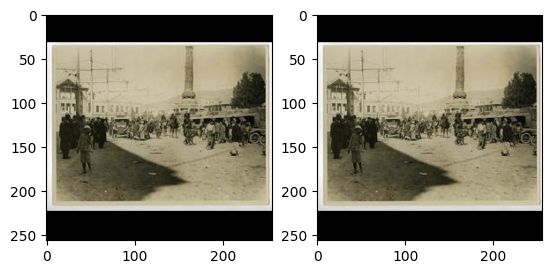

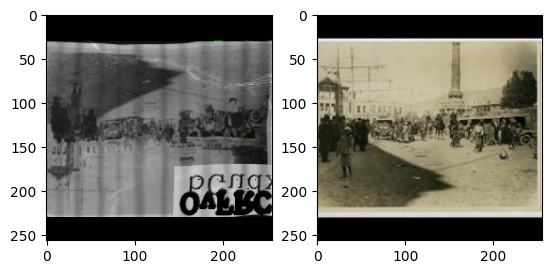

In [36]:
for batch in trainLoader:
    batch1 = transform_degrad(batch)
    batch2 = transform_degrad(batch)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(transforms.functional.to_pil_image(batch[0]))
    ax2.imshow(transforms.functional.to_pil_image(batch[0]))
    plt.show()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(transforms.functional.to_pil_image(batch1[0]))
    ax2.imshow(transforms.functional.to_pil_image(batch2[0]))
    plt.show()
    break

## Representation

In [3]:
class SimCLR_Representation(nn.Module):
    def __init__(self, encoder, in_dim=2048, out_dim=128):
        super(SimCLR_Representation, self).__init__()
        self.encoder = encoder
        self.projection = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
    
    def forward(self, x_):
        h = self.encoder(x_)
        z = self.projection(h)
        return z

In [ ]:
# ResNet18
representationEncoder = resnet18(weights=ResNet18_Weights.DEFAULT)
representationEncoder.fc = nn.Identity()

# ResNet50
#representationEncoder = resnet50(weights=ResNet50_Weights.DEFAULT)
#representationEncoder.fc = nn.Identity()
#model = SimCLR_Representation(representationEncoder, in_dim=2048).to(device)  # in_dim updated for ResNet50

# # MobileNet
# from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
# representationEncoder = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
# representationEncoder.classifier = nn.Identity()  # Remove classification head
# model = SimCLR_Representation(representationEncoder, in_dim=1280).to(device)  # in_dim for MobileNetV2


### Loss

In [ ]:
def infoNCEloss(z1, z2, t=1): # loss 1
    z = torch.cat([z1, z2], dim=0)

    s = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)
    exp_s = torch.exp(s / t)
    indicatorMask = torch.eye(s.shape[0], dtype=torch.bool, device=z.device) # True on diagonal, False elsewhere
    exp_s = exp_s.masked_fill(indicatorMask, 0)

    numerator = F.cosine_similarity(z1, z2, dim=-1)      # for z1
    numerator = torch.cat([numerator, numerator], dim=0) # for z2
    numerator = torch.exp(numerator / t)

    denominator = exp_s.sum(dim=1)

    l = -torch.log(numerator / denominator)
    return l.mean()


## Train

In [ ]:
model = SimCLR_Representation(representationEncoder, in_dim=512).to(device)
optimizer = optimizerFunc(model.parameters(), lr=learningRate)

lastBatch = images.shape[0] // batch_size

name = "degradations_simclr"
epochs = 200
writer = SummaryWriter(log_dir=f"logs/{name}")
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)  

model.train()

losses_all = []
for epoch in range(epochs):
    losses = []
    for i,sampledMinibatch in enumerate(tqdm(trainLoader, desc="Epoch " + str(epoch))):
        x = sampledMinibatch.to(device)
        # Transformation
        x_2 = transform_degrad(x)

        # Representation
        z1 = model(x)
        z2 = model(x_2)
        # Loss
        loss = infoNCEloss(z1, z2, temperature)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i != lastBatch:
            losses.append(loss.item())

    writer.add_scalar("Loss/train", torch.tensor(losses).mean(), epoch)
    losses_all.append(torch.tensor(losses).mean())
    torch.save(model.state_dict(), f"{name}.pth")
    scheduler.step()

plt.plot(losses_all)
plt.show()


## Test

In [3]:
xSim,_,ySim = lipade_groundtruth.getDataset(mode = 'similar', uniform=True)

imagesSim = []
for i in range(len(xSim)):
    try:
        imagesSim.append(Image.open(xSim[i]).convert('RGB'))
    except:
        print(xSim[i])

In [ ]:
name_test= "degradations_simclr"

In [9]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Nombre total de paramètres : {total_params}")
print(f"Nombre de paramètres entraînables : {trainable_params}")


Nombre total de paramètres : 2781568
Nombre de paramètres entraînables : 2781568


In [ ]:
testLoader = getDataLoader(imagesSim, None, None, False, batch_size, shuffle=False, num_workers=2)

representations = []
with torch.no_grad():
    for batch in testLoader:
        batch = model(batch.to(device))
        for repr in batch.tolist():
            representations.append(repr)

sim = cosine_similarity(representations, representations)

distance = 1 - (sim+1)/2
distance -= np.diag(distance)

np.save(resultsPath + f"simclr_{name_test}_mini_BBOPL.npy", distance)

Transitive closure « max–min » (Floyd–Warshall adaptée)

In [ ]:
# sim : matrice de similarité initiale, supposée dans [0,1]
n = sim.shape[0]
sim_prop = sim.copy()
sim_prop = (sim_prop+1)/2

for k in range(n):
    # broadcast sur i,j pour le sommet k
    via_k = np.minimum(sim_prop[:, k][:, None], sim_prop[k, :][None, :])
    sim_prop = np.maximum(sim_prop, via_k)

# revenir en distance :
distance_prop = 1 - sim_prop
np.fill_diagonal(distance_prop, 0)
np.save(resultsPath + f"simclr_{name_test}_max_min_dist_2.npy", distance_prop)

In [21]:
def transitive_closure_max_min(sim, steps=1, min_sim_threshold=0.2):
    sim_ = sim.copy()
    for _ in range(steps):
        for k in range(sim_.shape[0]):
            min_path = np.minimum(sim_[:, k][:, None], sim_[k, :][None, :])
            # ne propager que les liens suffisants
            sim_ = np.where(min_path > min_sim_threshold, np.maximum(sim_, min_path), sim_)
    return sim_

distance_prop = transitive_closure_max_min(sim)
np.save(resultsPath + f"simclr_{name_test}_max_min_dist_step.npy", distance_prop)

## Visualisation of learned embeddings

In [8]:
import seaborn as sns
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor

In [9]:
# SimCLR Feature Extractor
class SimCLRFeatureExtractor(nn.Module):
    def __init__(self, encoder=None, in_dim=512, out_dim=128):
        super(SimCLRFeatureExtractor, self).__init__()
        if encoder is None:
            self.encoder = resnet18(weights=ResNet18_Weights.DEFAULT)
            self.encoder.fc = nn.Identity()
        else:
            self.encoder = encoder

        self.projection = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
    def forward(self, x):
        return self.encoder(x)


In [10]:
import random

# Function to apply transformations and track applied transformations
def apply_transforms_and_track(image, transform):
    applied_transforms = []
    image = image.unsqueeze(0)
    # Manually apply and track transformations
    for t in transform.transforms:
        if isinstance(t, transforms.RandomApply):  
            if random.random() < t.p:  # Check if this RandomApply block is applied
                for sub_t in t.transforms:  
                    if isinstance(sub_t, transforms.RandomChoice):  
                        chosen_transform = random.choice(sub_t.transforms)  # Pick one
                        image = chosen_transform(image)  # Apply the picked transform
                        applied_transforms.append(f"{chosen_transform.__class__.__name__}")
                    else:
                        image = sub_t(image)
                        applied_transforms.append(sub_t.__class__.__name__)

        elif isinstance(t, transforms.RandomChoice):  
            chosen_transform = random.choice(t.transforms)  # Pick one
            image = chosen_transform(image)
            applied_transforms.append(f"{chosen_transform.__class__.__name__}")
        elif isinstance(t, transforms.RandomHorizontalFlip) or isinstance(t, transforms.RandomVerticalFlip):
            if random.random() < t.p:
                image = t(image)
                applied_transforms.append(t.__class__.__name__)

        else:
            image = t(image)
            applied_transforms.append(t.__class__.__name__)

            
    return image.squeeze(0), applied_transforms


In [11]:
# Dataset avec Transformations
class HistoricalDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        original = to_tensor(self.images[idx])
        transformed_image, applied_transforms = apply_transforms_and_track(original, self.transform)
        return original, transformed_image, applied_transforms

In [ ]:
# Chargement du modèle et extraction des embeddings
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []
    name_transformation = []

    with torch.no_grad():
        for idx, (orig, trans, name_trans) in enumerate(dataloader):
            orig, trans = orig.to(device), trans.to(device)
            
            emb_orig = model(orig).cpu().numpy()
            emb_trans = model(trans).cpu().numpy()
            
            embeddings.append(emb_orig)
            embeddings.append(emb_trans)
            
            labels.append(idx*2)  # Label pour original
            labels.append(idx*2)  # Label pour transformé
            name_transformation.append(name_trans)
            name_transformation.append(name_trans)
    return np.vstack(embeddings), np.array(labels), name_transformation


def get_embbedings(model_architecture,path, num_points=20, transform=transform_degrad):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_no_train = model_architecture().to(device)
    model = model_architecture().to(device)
    model.load_state_dict(torch.load(path, weights_only=True, map_location=torch.device('cpu')))

    x,_,y = lipade_groundtruth.getDataset(mode = 'unique', uniform=True)

    images = []
    for i in range(len(x[:num_points])):
        images.append(Image.open(x[i]).convert('RGB'))
    images = np.array(images)
    
    dataset = HistoricalDataset(images, transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Extract raw features (before train)
    raw_features, raw_labels, raw_transformations = extract_embeddings(model_no_train, dataloader, device)

    # Extraire les embeddings (after train)
    learned_embeddings, learned_labels, learned_transformations = extract_embeddings(model, dataloader, device)

    return raw_features, learned_embeddings, raw_labels, raw_transformations

In [17]:
import altair as alt
import pandas as pd
from sklearn.manifold import TSNE
import umap

def visualize_combined(embeddings_raw, embeddings_learned, transformations, raw_labels, method="TSNE"):
    
    if method == "TSNE":
        # Apply t-SNE to reduce dimensions to 2D
        all_embeddings = np.vstack([embeddings_raw, embeddings_learned])
        tsne = TSNE(n_components=2, random_state=42)
        reduced = tsne.fit_transform(all_embeddings)
    
    elif method == "UMAP":
        all_embeddings = np.vstack([embeddings_raw, embeddings_learned])
        reducer = umap.UMAP()
        reduced = reducer.fit_transform(all_embeddings)
    else:
        raise ValueError("Method must be either 'TSNE' or 'UMAP'")

    num_pairs = len(embeddings_raw) // 2  # Each pair has an original & augmented image

    # Extract raw and learned embeddings correctly
    reduced_raw = reduced[:len(embeddings_raw)]
    reduced_learned = reduced[len(embeddings_raw):]
    labels = raw_labels + len(raw_labels)

    # Create DataFrame for Altair
    df = pd.DataFrame({
        'x': np.concatenate([reduced_raw[:, 0], reduced_learned[:, 0]]),
        'y': np.concatenate([reduced_raw[:, 1], reduced_learned[:, 1]]),
        'type': ['Avant'] * len(reduced_raw) + ['Après'] * len(reduced_learned),
        'pair_id_rl': list(range(len(reduced_raw)))*2,  # Pairing raw & learned embeddings
        'pair_id_full': np.concatenate([raw_labels,raw_labels]),
        'pair_id': np.concatenate([raw_labels,labels]), # Pairing original & transformed pictures
        'transformation': transformations # Ensure transformations match the pairs
    })
    # Create a selection for hover interaction
    hover = alt.selection_single(fields=['pair_id'], nearest=True, on='mouseover', empty='none')
    hover_pair = alt.selection_single(fields=['pair_id'], nearest=True, on='mouseover', empty='none')
    hover_pair_all = alt.selection_single(fields=['pair_id_full'], on='mouseover', empty='none')

    # Scatter plot for raw & learned embeddings
    title = alt.TitleParams(f'Visualisation des embeddings ({method}) des images et leurs dégradations avant et après entraînement du modèle', anchor='middle')
    scatter = alt.Chart(df, title=title).mark_circle(size=80).encode(
        x='x',
        y='y',
        color=alt.condition(
            hover_pair_all, alt.value('yellow'),  # Yellow for pair_id
            alt.condition(
                hover_pair, alt.value('purple'),  # Purple for pair_id_rl
                alt.Color('type:N', scale=alt.Scale(domain=['Avant', 'Après'], range=['blue', 'red']))
            )
        ),
        tooltip=['type', 'transformation']
    ).add_selection(
        hover_pair
    ).add_selection(
        hover_pair_all
    )

    # Line segments connecting pairs
    lines = alt.Chart(df).mark_line(opacity=0.4, color='gray').encode(
        x='x',
        y='y',
        detail='pair_id_rl'
    )

    # Combine scatter plot and lines
    chart = lines + scatter
    return chart.properties(width='container')


In [ ]:
model_architecture = SimCLRFeatureExtractor
path = '../results/weights/simclr/model_1by1.pth'
raw_features, learned_embeddings, labels, transformations = get_embbedings(model_architecture,path,10)

# Display the chart
visualize_combined(raw_features, learned_embeddings, transformations*2, labels).show()

alt.LayerChart(...)

In [ ]:
# tranformations 1 by 1
def get_embbedings_1by1(model_architecture, path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_no_train = model_architecture().to(device)
    model = model_architecture().to(device)
    model.load_state_dict(torch.load(path, weights_only=True, map_location=torch.device('cpu')))

    x,_,y = lipade_groundtruth.getDataset(mode = 'unique', uniform=True)

    
    transforms_1by1 = [
    transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(1/2, 1), ratio=(1, 1))]), 
    transforms.Compose([transforms_floyd_steinberg_halftoning()]),
    transforms.Compose([transforms_atkinson_dithering()]),
    transforms.Compose([transforms_bayer_halftoning()]),
    transforms.Compose([transforms_picture_overlay()]),
    transforms.Compose([transforms_text_overlay()]),
    transforms.Compose([transforms_torn_paper()]),
    transforms.Compose([transforms_non_rectangular_frame()]),
    transforms.Compose([transforms_erased_element()]),
    transforms.Compose([transforms_drawing()]),
    transforms.Compose([transforms_paint()]),
    transforms.Compose([transforms_add_gaussian_noise()]),
    transforms.Compose([transforms_add_salt_and_pepper_noise()]),
    transforms.Compose([transforms_dirty_rollers()]),
    #transforms.Compose([transforms_scribbles()]),
    transforms.Compose([transforms_stains()]),
    transforms.Compose([transforms_ink_bleed()]),
    transforms.Compose([transforms_bleedthrough()]),
    transforms.Compose([transforms_crumpled_paper()]),
    #transforms.Compose([transforms_folded_paper()]),
    transforms.Compose([transforms.RandomHorizontalFlip(p=0.2)]),
    transforms.Compose([transforms.RandomVerticalFlip(p=0.2)]),
    transforms.Compose([transforms.GaussianBlur(kernel_size=9)]),
    transforms.Compose([transforms_SepiaFilter()]),
    transforms.Compose([transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2)
        ])]
    
    images = []
    for i in range(len(transforms_1by1)):
        images.append(Image.open(x[i]).convert('RGB'))
    images = np.array(images)

    handmade_dataloader = []
    for img, trans in zip(images, transforms_1by1):
        img = to_tensor(img)
        img_trans, applied_transform = apply_transforms_and_track(img, trans)
        handmade_dataloader.append((img.unsqueeze(0),img_trans.unsqueeze(0),applied_transform))

    # Extract raw features (before train)
    raw_features, raw_labels, raw_transformations = extract_embeddings(model_no_train, handmade_dataloader, device)

    # Extraire les embeddings (after train)
    learned_embeddings, learned_labels, learned_transformations = extract_embeddings(model, handmade_dataloader, device)

    return raw_features, learned_embeddings, raw_labels, raw_transformations


In [ ]:
model_architecture = SimCLRFeatureExtractor
path = '../results/weights/simclr/model_1by1.pth'
raw_features, learned_embeddings, labels, transformations = get_embbedings_1by1(model_architecture, path)
visualize_combined(raw_features, learned_embeddings, transformations*2, labels).show()

alt.LayerChart(...)

Histogrammes des différences

In [ ]:
def histogram(model_architecture, path, nb_images=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_no_train = model_architecture().to(device)
    model_no_train.eval()
    model = model_architecture().to(device)
    model.load_state_dict(torch.load(path, weights_only=True, map_location=torch.device('cpu')))
    model.eval()

    x,_,y = lipade_groundtruth.getDataset(mode = 'unique', uniform=True)

    
    transforms_1by1 = [
    transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(1/2, 1), ratio=(1, 1))]), 
    transforms.Compose([transforms_floyd_steinberg_halftoning()]),
    transforms.Compose([transforms_atkinson_dithering()]),
    transforms.Compose([transforms_bayer_halftoning()]),
    transforms.Compose([transforms_picture_overlay()]),
    transforms.Compose([transforms_text_overlay()]),
    transforms.Compose([transforms_torn_paper()]),
    #transforms.Compose([transforms_non_rectangular_frame()]),
    transforms.Compose([transforms_erased_element()]),
    transforms.Compose([transforms_drawing()]),
    transforms.Compose([transforms_paint()]),
    transforms.Compose([transforms_add_gaussian_noise()]),
    transforms.Compose([transforms_add_salt_and_pepper_noise()]),
    transforms.Compose([transforms_dirty_rollers()]),
    #transforms.Compose([transforms_scribbles()]),
    transforms.Compose([transforms_stains()]),
    transforms.Compose([transforms_ink_bleed()]),
    transforms.Compose([transforms_bleedthrough()]),
    transforms.Compose([transforms_crumpled_paper()]),
    #transforms.Compose([transforms_folded_paper()]),
    transforms.Compose([transforms.RandomHorizontalFlip(p=0.2)]),
    transforms.Compose([transforms.RandomVerticalFlip(p=0.2)]),
    transforms.Compose([transforms.GaussianBlur(kernel_size=9)]),
    transforms.Compose([transforms_SepiaFilter()]),
    transforms.Compose([transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2)
                        ])]
    
    names = ["Crop", "floyd_steinberg", "atkinson", "bayer", "picture_overlay",
    "text_overlay", "torn_paper", 
    #"frame", 
    "erased_element", "drawing", "paint", "gaussian", "salt_pepper", "dirty_rollers",
    #scribbles,
    "stains", "ink_bleed", "bleedthrough", "crumpled_paper",
    #folded_paper,
    "HorizontalFlip", "VerticalFlip", "Blur", "Sepia", "ColorJitter"]
    
    images = []
    for i in range(nb_images):
        images.append(Image.open(x[i]).convert('RGB'))
    images = np.array(images)



    def similarity(a, b):
        return cosine_similarity(a, b).item()

    differences = {"raw":[], "learn":[]}
    for trans in transforms_1by1:

        raw = []
        learn = []
        for img in images:
            img = to_tensor(img)
            emb_raw_origin = model_no_train(img.unsqueeze(0)).detach()
            emb_learn_origin = model(img.unsqueeze(0)).detach()

            img_trans = trans(img.unsqueeze(0))
            emb_raw_trans = model_no_train(img_trans).detach()
            emb_learn_trans = model(img_trans).detach()
            raw.append(similarity(emb_raw_trans, emb_raw_origin)) # ????? métrique de distance ?????
            learn.append(similarity(emb_learn_trans, emb_learn_origin)) # ????? métrique de distance ?????
        
        raw = np.array(raw).mean()
        learn = np.array(learn).mean()
        differences["raw"].append(raw)
        differences["learn"].append(learn)


    x = np.arange(len(names))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(25,5))

    for attribute, measurement in differences.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('cosine similarity')
    ax.set_title('Similarity between image embeddings')
    ax.set_xticks(x + width, names)
    ax.legend(loc='upper left', ncols=2)

    plt.show()

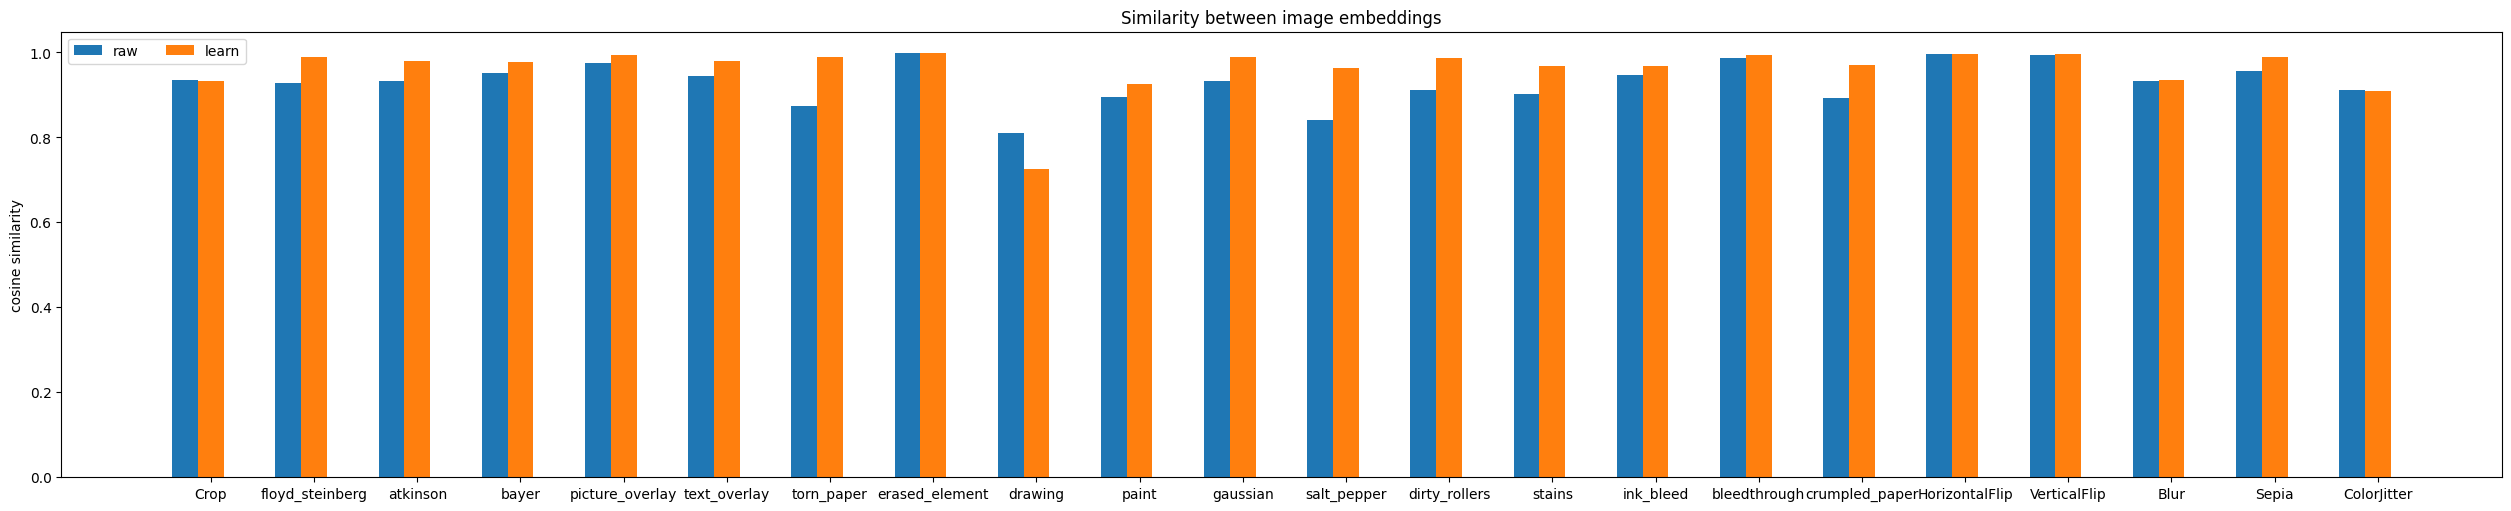

In [20]:
model_architecture = SimCLRFeatureExtractor
path = '../results/weights/simclr/model_1by1.pth'
histogram(model_architecture, path, 50)
